<a href="https://colab.research.google.com/github/Safayat777/my_new/blob/main/snn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import spikegen
from snntorch import functional as SF

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = ImageFolder('/content/drive/MyDrive/DataSet/ArsenicSkinImageBD', transform=transform)
test_dataset  = ImageFolder('/content/drive/MyDrive/DataSet/Original', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
classes = train_dataset.classes
print(classes)

['infected', 'not_infected']


In [ ]:
num_steps = 30       # time steps (higher = better accuracy)
beta = 0.95          # membrane decay
epochs = 20
lr = 0.001

In [ ]:
class SNN_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 5)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.lif2 = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(32 * 20 * 20, 2) # Corrected input features
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []

        for step in range(num_steps):
            cur1 = self.conv1(x)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc1(spk2.view(x.size(0), -1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = SF.ce_rate_loss()

In [ ]:
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        # Spike Encoding
        data_spike = spikegen.rate(data, num_steps=num_steps)

        optimizer.zero_grad()
        spk_out = model(data_spike[0])
        loss = loss_fn(spk_out, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        pred = spk_out.sum(dim=0).argmax(dim=1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    avg_loss = total_loss / len(train_loader)
    acc = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}  Accuracy: {acc:.2f}%")

Epoch [1/20]  Loss: 0.6930  Accuracy: 50.22%
Epoch [2/20]  Loss: 0.6908  Accuracy: 52.99%
Epoch [3/20]  Loss: 0.6878  Accuracy: 53.36%
Epoch [4/20]  Loss: 0.6879  Accuracy: 52.33%
Epoch [5/20]  Loss: 0.6774  Accuracy: 57.01%
Epoch [6/20]  Loss: 0.6610  Accuracy: 57.61%
Epoch [7/20]  Loss: 0.6585  Accuracy: 58.91%
Epoch [8/20]  Loss: 0.6564  Accuracy: 59.04%
Epoch [9/20]  Loss: 0.6573  Accuracy: 59.36%
Epoch [10/20]  Loss: 0.6527  Accuracy: 61.11%
Epoch [11/20]  Loss: 0.6496  Accuracy: 60.90%
Epoch [12/20]  Loss: 0.6482  Accuracy: 61.41%
Epoch [13/20]  Loss: 0.6463  Accuracy: 62.08%
Epoch [14/20]  Loss: 0.6458  Accuracy: 61.75%
Epoch [15/20]  Loss: 0.6419  Accuracy: 62.66%
Epoch [16/20]  Loss: 0.6375  Accuracy: 63.33%
Epoch [17/20]  Loss: 0.6388  Accuracy: 62.76%
Epoch [18/20]  Loss: 0.6395  Accuracy: 62.17%
Epoch [19/20]  Loss: 0.6336  Accuracy: 63.69%
Epoch [20/20]  Loss: 0.6340  Accuracy: 63.17%


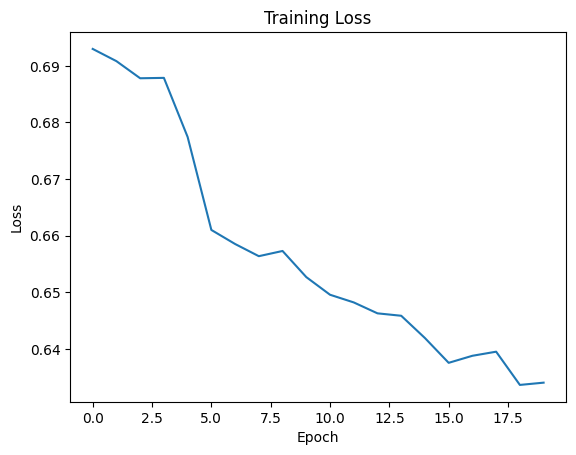

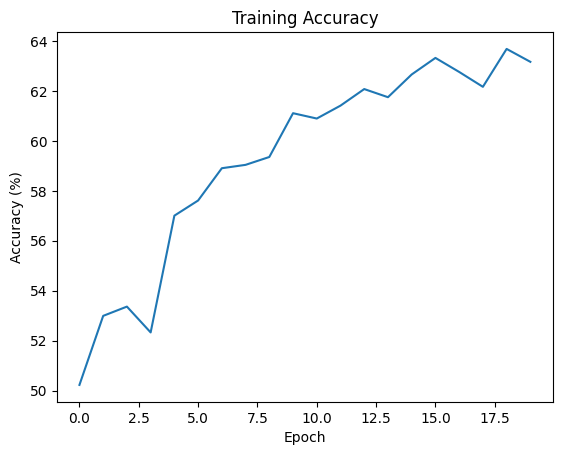

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        data_spike = spikegen.rate(data, num_steps=num_steps)

        spk_out = model(data_spike[0])
        pred = spk_out.sum(dim=0).argmax(dim=1)

        correct += (pred == targets).sum().item()
        total += targets.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 68.07%


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving infected.png to infected (1).png


In [ ]:
def predict_image(image_path):
    img = Image.open(image_path).convert('L')
    img = transform(img)
    img = img.unsqueeze(0).to(device)

    img_spike = spikegen.rate(img, num_steps=num_steps)

    with torch.no_grad():
        spk_out = model(img_spike[0])
        pred = spk_out.sum(dim=0).argmax(dim=1)

    return classes[pred.item()]


In [ ]:
for file in uploaded.keys():
    result = predict_image(file)
    print(f"Prediction: {result}")


Prediction: infected
